In [3]:
import json
import pandas as pd

def load_and_merge_data(filepath1: str, filepath2: str) -> dict:
    """Load JSON data from two files and merge them."""
    with open(filepath1, 'r') as f1, open(filepath2, 'r') as f2:
        data1 = json.load(f1)
        data2 = json.load(f2)
    # Merge the dictionaries, with data2 overwriting data1 in case of conflicts
    merged_data = {**data1, **data2}
    return merged_data

def create_ml_dataframe(data: dict) -> pd.DataFrame:
    """Create a DataFrame with the specified features for ML analysis."""
    records = []
    
    for artist, attributes in data.items():
        # Basic attributes
        popularity = attributes.get('popularity', 0)
        followers = attributes.get('followers', 0)
        
        # Collaborator-based features
        collaborators = attributes.get('collaborators', {})
        num_collaborators = len(collaborators)
        
        sum_collab_popularity = 0
        sum_collab_in_playlist = 0
        for collab_name, collab_info in collaborators.items():
            # Sum collaborator popularity if available in the dataset
            collab_popularity = data.get(collab_name, {}).get('popularity', 0)
            sum_collab_popularity += collab_popularity
            # Count if collaborator is in the playlist
            collab_in_playlist = data.get(collab_name, {}).get('in_playlist', False)
            sum_collab_in_playlist += int(collab_in_playlist)
        
        # Add each artist's record to the dataset
        records.append({
            'name': artist,
            'popularity': popularity,
            'followers': followers,
            'num_collaborators': num_collaborators,
            'sum_collaborators_popularity': sum_collab_popularity,
            'sum_collaborators_in_playlist': sum_collab_in_playlist,
            'in_playlist': int(attributes.get('in_playlist', False)),
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(records)
    return df

# Load and merge data from the two JSON files
data = load_and_merge_data('11_08_playlist_layer2.json', '10_26_random_2layer.json')

# Create the ML DataFrame
df_ml = create_ml_dataframe(data)

# Save to CSV for ML analysis
df_ml.to_csv('ml_dataset.csv', index=False)
print("ML dataset created and saved to 'ml_dataset.csv'")


ML dataset created and saved to 'ml_dataset.csv'


In [4]:
df_ml.head()

,name,popularity,followers,num_collaborators,sum_collaborators_popularity,sum_collaborators_in_playlist,in_playlist
0,ROSÉ,84,7766971,5,326,2,1
1,Bruno Mars,94,60240128,25,1816,3,1
2,Billie Eilish,96,100730714,13,899,1,1
3,Sabrina Carpenter,95,13640801,20,1325,3,1
4,Sevdaliza,77,704987,15,929,2,1


In [6]:
df_ml.describe()

,popularity,followers,num_collaborators,sum_collaborators_popularity,sum_collaborators_in_playlist,in_playlist
count,3857.000000,3.857000e+03,3857.000000,3857.000000,3857.000000,3857.000000
mean,39.244491,1.230998e+06,18.742546,296.782214,0.387348,0.035261
std,24.011799,6.364674e+06,22.512729,450.290474,0.674310,0.184462
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,19.000000,6.050000e+02,6.000000,75.000000,0.000000,0.000000
50%,40.000000,9.202000e+03,13.000000,162.000000,0.000000,0.000000
75%,57.000000,2.208490e+05,22.000000,319.000000,1.000000,0.000000
max,100.000000,1.244311e+08,230.000000,5687.000000,6.000000,1.000000


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

# Load your data
df = pd.read_csv('ml_dataset.csv')

# Separate features and target variable
X = df[['popularity', 'followers', 'num_collaborators', 'sum_collaborators_popularity', 'sum_collaborators_in_playlist']]
y = df['in_playlist']

# Split into training (90%) and testing (10%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(),
    'Neural Network (MLP)': MLPClassifier(max_iter=300)
}

# Cross-validation and model evaluation
for model_name, model in models.items():
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    print(f"{model_name} - Cross-Validation F1 Score: {cv_scores.mean():.2f}")
    
    # Fit model and make predictions
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print results
    print(f"{model_name} - Test Set Performance:")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print("-" * 30)


Logistic Regression - Cross-Validation F1 Score: 0.53
Logistic Regression - Test Set Performance:
  Accuracy: 0.96
  Precision: 0.50
  Recall: 0.56
  F1 Score: 0.53
------------------------------
Random Forest - Cross-Validation F1 Score: 0.58
Random Forest - Test Set Performance:
  Accuracy: 0.97
  Precision: 0.60
  Recall: 0.56
  F1 Score: 0.58
------------------------------
Support Vector Classifier - Cross-Validation F1 Score: 0.54
Support Vector Classifier - Test Set Performance:
  Accuracy: 0.96
  Precision: 0.50
  Recall: 0.56
  F1 Score: 0.53
------------------------------
Decision Tree - Cross-Validation F1 Score: 0.47
Decision Tree - Test Set Performance:
  Accuracy: 0.96
  Precision: 0.57
  Recall: 0.50
  F1 Score: 0.53
------------------------------
Gradient Boosting - Cross-Validation F1 Score: 0.58
Gradient Boosting - Test Set Performance:
  Accuracy: 0.96
  Precision: 0.55
  Recall: 0.38
  F1 Score: 0.44
------------------------------


d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:49:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:49:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:49:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\zqw\2024fall\

XGBoost - Cross-Validation F1 Score: 0.56
XGBoost - Test Set Performance:
  Accuracy: 0.96
  Precision: 0.56
  Recall: 0.62
  F1 Score: 0.59
------------------------------


d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:49:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 96, number of negative: 2680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 2776, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034582 -> initscore=-3.329224
[LightGBM] [Info] Start training from score -3.329224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 96, number of negative: 2681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overh

d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network (MLP) - Cross-Validation F1 Score: 0.56
Neural Network (MLP) - Test Set Performance:
  Accuracy: 0.96
  Precision: 0.53
  Recall: 0.50
  F1 Score: 0.52
------------------------------


In [14]:
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid
param_grid = {
    'learning_rate': [0.15, 0.2, 0.5],
    'max_depth': [2, 3, 4],
    'n_estimators': [80, 100, 150],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBoost model
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluate the tuned model on the test set
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Tuned XGBoost - Test Set Performance:")
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Precision: {precision:.2f}")
print(f"  Recall: {recall:.2f}")
print(f"  F1 Score: {f1:.2f}")


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 80, 'subsample': 1.0}
Best F1 Score: 0.6228338753313475
Tuned XGBoost - Test Set Performance:
  Accuracy: 0.96
  Precision: 0.53
  Recall: 0.50
  F1 Score: 0.52


d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:53:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [30, 50, 70],          # Number of trees
    'max_depth': [None],         # Maximum depth of trees
    'min_samples_split': [8, 10, 15],         # Minimum samples to split a node
    'min_samples_leaf': [1],           # Minimum samples at a leaf node
    'max_features': [None]   # Number of features to consider for splits
}

# Initialize RandomForest model
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best F1 score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluate the tuned model on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Tuned Random Forest - Test Set Performance:")
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Precision: {precision:.2f}")
print(f"  Recall: {recall:.2f}")
print(f"  F1 Score: {f1:.2f}")


Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 70}
Best F1 Score: 0.6030461599245794
Tuned Random Forest - Test Set Performance:
  Accuracy: 0.96
  Precision: 0.50
  Recall: 0.50
  F1 Score: 0.50


In [17]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train Random Forest and XGBoost on the SMOTE-resampled data
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{model_name} with SMOTE - Test Set Performance:")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print("-" * 30)


Random Forest with SMOTE - Test Set Performance:
  Accuracy: 0.96
  Precision: 0.54
  Recall: 0.94
  F1 Score: 0.68
------------------------------
XGBoost with SMOTE - Test Set Performance:
  Accuracy: 0.97
  Precision: 0.58
  Recall: 0.94
  F1 Score: 0.71
------------------------------


d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:01:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [25]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Initialize stratified cross-validation
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on SMOTE-resampled data
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, learning_rate=0.1, max_depth=5, n_estimators=150)
cv_scores = cross_val_score(xgb, X_resampled, y_resampled, cv=stratified_kf, scoring='f1')

print("Stratified K-Fold CV F1 Score:", cv_scores.mean())


d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\zqw\2024fall\

Stratified K-Fold CV F1 Score: 0.9906680623752017


d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:09:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [29]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Initialize XGBoost model with initial parameters
final_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

# Train the final model on SMOTE-resampled data
final_xgb.fit(X_resampled, y_resampled)

# Make predictions on the original test set
y_pred = final_xgb.predict(X_test_scaled)

# Evaluate final model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Final XGBoost Model with SMOTE - Test Set Performance:")
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Precision: {precision:.2f}")
print(f"  Recall: {recall:.2f}")
print(f"  F1 Score: {f1:.2f}")

# Save the final model
joblib.dump(final_xgb, "final_xgb_model_with_smote.pkl")
print("Model saved as 'final_xgb_model_with_smote.pkl'")


Final XGBoost Model with SMOTE - Test Set Performance:
  Accuracy: 0.97
  Precision: 0.58
  Recall: 0.94
  F1 Score: 0.71
Model saved as 'final_xgb_model_with_smote.pkl'


d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:15:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## ML model with Network Features

In [5]:
import pandas as pd
import ast
from tqdm import tqdm  # For the progress bar

def load_csv_data(filepath: str) -> pd.DataFrame:
    """Load the CSV data and preprocess the 'collaborators' column."""
    # Load the data
    df_network = pd.read_csv(filepath)

    # Parse the 'collaborators' column from string to dictionary
    df_network['collaborators'] = df_network['collaborators'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else {})

    return df_network

def create_ml_dataframe(df_network: pd.DataFrame) -> pd.DataFrame:
    """Create a DataFrame with the specified features for ML analysis."""
    records = []
    
    # Wrap the DataFrame iteration with tqdm for a progress bar
    for _, row in tqdm(df_network.iterrows(), total=df_network.shape[0], desc="Processing rows"):
        # Basic attributes
        artist_name = row['name']
        artist_popularity = row['popularity']
        artist_followers = row['followers']
        artist_pagerank = row['pagerank']
        artist_closeness_cent = row['closeness_cent']
        artist_clustering = row['clustering']
        artist_deg_cent = row['deg_cent']
        artist_degree = row['degree']
        
        # Collaborator-based features
        artist_collaborators = row['collaborators']
        num_collaborators = len(artist_collaborators)
        
        sum_collab_popularity = 0
        sum_collab_in_playlist = 0
        for collab_name, collab_info in artist_collaborators.items():
            # Sum collaborator popularity if available in the dataset
            collab_popularity = df_network[df_network['name'] == collab_name]['popularity'].sum()
            sum_collab_popularity += collab_popularity
            # Count if collaborator is in the playlist
            collab_in_playlist = df_network[df_network['name'] == collab_name]['in_playlist'].sum()
            sum_collab_in_playlist += collab_in_playlist
        
        # Add each artist's record to the dataset
        records.append({
            'name': artist_name,
            'popularity': artist_popularity,
            'followers': artist_followers,
            'pagerank': artist_pagerank,
            'closeness_cent': artist_closeness_cent,
            'clustering': artist_clustering,
            'deg_cent': artist_deg_cent,
            'degree': artist_degree,
            'num_collaborators': num_collaborators,
            'sum_collaborators_popularity': sum_collab_popularity,
            'sum_collaborators_in_playlist': sum_collab_in_playlist,
            'in_playlist': int(row['in_playlist']),
        })
    
    # Convert to DataFrame
    df_ml_network = pd.DataFrame(records)
    return df_ml_network

# Load the new data from CSV
df_network = load_csv_data('week1.csv')

# Create the ML DataFrame
df_ml_network = create_ml_dataframe(df_network)

# Save to CSV for ML analysis
df_ml_network.to_csv('ml_dataset_2.csv', index=False)
print("ML dataset created and saved to 'ml_dataset_2.csv'")



Processing rows: 100%|██████████| 15126/15126 [01:58<00:00, 127.31it/s] 


ML dataset created and saved to 'ml_dataset_2.csv'


#### Find the best model

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Load the new dataset
df = pd.read_csv('ml_dataset_2.csv')

# Separate features and target variable
X = df[['popularity', 'followers', 'pagerank', 'closeness_cent', 'clustering', 'deg_cent', 'degree', 
        'num_collaborators', 'sum_collaborators_popularity', 'sum_collaborators_in_playlist']]
y = df['in_playlist']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define models for evaluation
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'Neural Network (MLP)': MLPClassifier(max_iter=300, random_state=42)
}

# Evaluate each model
best_model = None
best_f1 = 0
for model_name, model in models.items():
    # Train the model
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{model_name} - Test Set Performance:")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print("-" * 30)
    
    # Track the best model
    if f1 > best_f1:
        best_f1 = f1
        best_model = model

# Save the best model
joblib.dump(best_model, "best_model_with_smote_new_data.pkl")
print(f"Best model saved as 'best_model_with_smote_new_data.pkl' with F1 Score: {best_f1:.2f}")


Random Forest - Test Set Performance:
  Accuracy: 0.99
  Precision: 0.64
  Recall: 1.00
  F1 Score: 0.78
------------------------------
XGBoost - Test Set Performance:
  Accuracy: 0.99
  Precision: 0.54
  Recall: 0.93
  F1 Score: 0.68
------------------------------


d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:22:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 13485, number of negative: 13485
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26970, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM - Test Set Performance:
  Accuracy: 0.99
  Precision: 0.54
  Recall: 1.00
  F1 Score: 0.70
------------------------------
Neural Network (MLP) - Test Set Performance:
  Accuracy: 0.99
  Precision: 0.54
  Recall: 1.00
  F1 Score: 0.70
------------------------------
Best model saved as 'best_model_with_smote_new_data.pkl' with F1 Score: 0.78


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the new dataset
df = pd.read_csv('ml_dataset_2.csv')

# Separate features and target variable
X = df[['popularity', 'followers', 'pagerank', 'closeness_cent', 'clustering', 'deg_cent', 'degree',
        'num_collaborators', 'sum_collaborators_popularity', 'sum_collaborators_in_playlist']]
y = df['in_playlist']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV for hyperparameter tuning
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    scoring='f1',
    n_jobs=-1
)

# Fit the RandomizedSearchCV
rf_random.fit(X_resampled, y_resampled)

# Get the best parameters and model
best_rf = rf_random.best_estimator_
print("Best Parameters:", rf_random.best_params_)

# Evaluate the tuned Random Forest on the test set
y_pred = best_rf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Tuned Random Forest - Test Set Performance:")
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Precision: {precision:.2f}")
print(f"  Recall: {recall:.2f}")
print(f"  F1 Score: {f1:.2f}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Tuned Random Forest - Test Set Performance:
  Accuracy: 0.99
  Precision: 0.67
  Recall: 0.86
  F1 Score: 0.75


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the new dataset
df = pd.read_csv('ml_dataset_2.csv')

# Separate features and target variable
X = df[['popularity', 'followers', 'pagerank', 'closeness_cent', 'clustering', 'deg_cent', 'degree',
        'num_collaborators', 'sum_collaborators_popularity', 'sum_collaborators_in_playlist']]
y = df['in_playlist']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define an expanded parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV for hyperparameter tuning
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=100,  # Number of random samples
    cv=3,  # Cross-validation folds
    verbose=2,
    random_state=42,
    scoring='f1',  # Focus on F1 score
    n_jobs=-1  # Use all available CPUs
)

# Fit the RandomizedSearchCV
rf_random.fit(X_resampled, y_resampled)

# Get the best parameters and model
best_rf = rf_random.best_estimator_
print("Best Parameters:", rf_random.best_params_)

# Evaluate the tuned Random Forest on the test set
y_pred = best_rf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Tuned Random Forest with Expanded Search - Test Set Performance:")
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Precision: {precision:.2f}")
print(f"  Recall: {recall:.2f}")
print(f"  F1 Score: {f1:.2f}")

# Save the tuned model
import joblib
joblib.dump(best_rf, "tuned_rf_with_smote.pkl")
print("Model saved as 'tuned_rf_with_smote.pkl'")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Tuned Random Forest with Expanded Search - Test Set Performance:
  Accuracy: 1.00
  Precision: 0.68
  Recall: 0.93
  F1 Score: 0.79
Model saved as 'tuned_rf_with_smote.pkl'


In [12]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define an expanded parameter grid
param_grid = {
    'n_estimators': [550, 600, 1000],
    'max_depth': [None],
    'min_samples_split': [5, 6],
    'min_samples_leaf': [1],
    'max_features': ['log2'],
    'bootstrap': [False]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV for hyperparameter tuning
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=100,  # Number of random samples
    cv=3,  # Cross-validation folds
    verbose=2,
    random_state=42,
    scoring='f1',  # Focus on F1 score
    n_jobs=-1  # Use all available CPUs
)

# Fit the RandomizedSearchCV
rf_random.fit(X_resampled, y_resampled)

# Get the best parameters and model
best_rf = rf_random.best_estimator_
print("Best Parameters:", rf_random.best_params_)

# Evaluate the tuned Random Forest on the test set
y_pred = best_rf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Tuned Random Forest with Expanded Search - Test Set Performance:")
print(f"  Accuracy: {accuracy:.5f}")
print(f"  Precision: {precision:.5f}")
print(f"  Recall: {recall:.5f}")
print(f"  F1 Score: {f1:.5f}")

# Save the tuned model
import joblib
joblib.dump(best_rf, "tuned_rf_with_smote.pkl")
print("Model saved as 'tuned_rf_with_smote.pkl'")

d:\zqw\2024fall\SI608\final\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'n_estimators': 550, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Tuned Random Forest with Expanded Search - Test Set Performance:
  Accuracy: 0.99537
  Precision: 0.68421
  Recall: 0.92857
  F1 Score: 0.78788
Model saved as 'tuned_rf_with_smote.pkl'


                         Feature  Importance
9  sum_collaborators_in_playlist    0.444489
8   sum_collaborators_popularity    0.173175
7              num_collaborators    0.105647
4                     clustering    0.090726
6                         degree    0.044016
5                       deg_cent    0.039734
0                     popularity    0.033555
3                 closeness_cent    0.033217
1                      followers    0.021236
2                       pagerank    0.014205


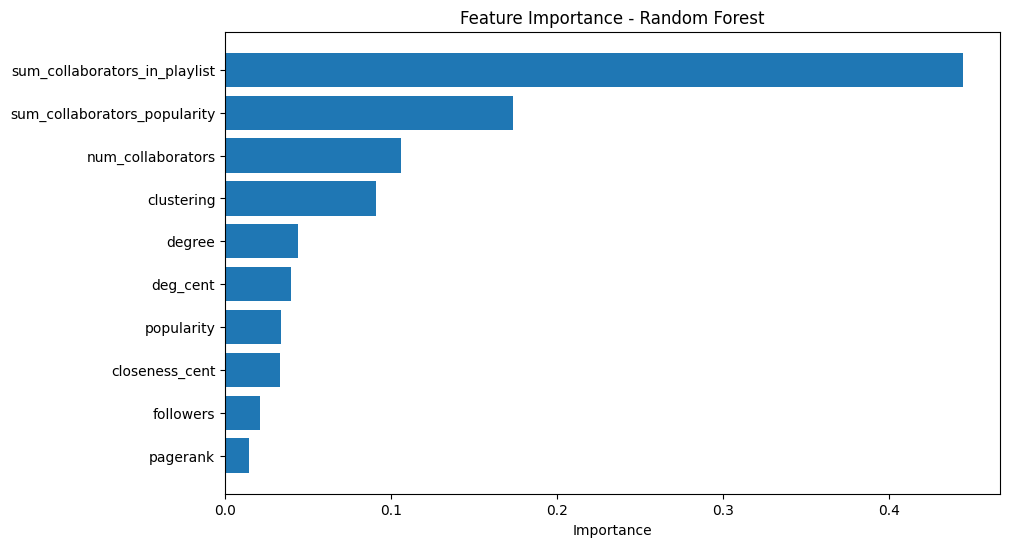

In [14]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved model
rf_model = joblib.load("tuned_rf_with_smote.pkl")

# Define feature names (matching the input features used during training)
feature_names = [
    'popularity', 
    'followers', 
    'pagerank', 
    'closeness_cent', 
    'clustering', 
    'deg_cent', 
    'degree', 
    'num_collaborators', 
    'sum_collaborators_popularity', 
    'sum_collaborators_in_playlist'
]

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()
